## EGM with endogenous labor supply

This notebook extends the EGM to an elastic labor supply using the method outlined in Maliar and Maliar (2013): "Envelope condition method versus endogenous grid method for solving dynamic programming problems", section 4.1. The utility function used in this notebook is

$$u(c_t, l_t) = \frac{c_t^{1-\gamma}}{1-\gamma} - \phi \frac{l_t^{1+v}}{1+v}$$

The only additional step tha tis required to solve problems with elastic labor supply ***and preferences that are separable in consumption and labor*** is to use a root finding method when the labor supply binds. This is because the euler equations pins down current consumption (given future consumption, which is the guess in EGM), which in turn pins down labor supply through the intratemporal first order condition. If preferences were not separable, you would have to solve these two first order conditions jointly, which would introduce a root finding procedure for **each** iteration of

In [105]:
include("rowenhorst_tauchen.jl") # include discretization functions (make sure it is in your working directory)

using Parameters, Plots, LinearAlgebra, Interpolations, BenchmarkTools, Roots

Household = @with_kw (apoints = 500, #asset grid
    amax = 200,  # asset max
    beta = 0.98, # discount factor
    alpha = 0.11, # capital share
    deprec = 0.025, # depreciation rate
    gamma = 1, # elasticity of substitution
    bc = 0, # borrowing constraint (must be weakly negative)
    rho = 0.966,  # autocorr of income process
    num_states = 7, # number of states for income process
    sd = 0.13, # stand. dev. of deviation process
    mean = 0, # mean of income process
    uncond_sd = 0.13/sqrt(1-rho^2), # unconditional sd
    transition_matrix = rowenhorst(mean, uncond_sd, rho, num_states)[1], # transition matrix
    ygrid = rowenhorst(mean, uncond_sd, rho, num_states)[2], # grid for income process
    Amat = setgrids(bc, apoints, amax, num_states, ygrid)[1], # asset grid
    Ymat = setgrids(bc, apoints, amax, num_states, ygrid)[2], # income grid
    phi = 0.8, # disutility factor
    frisch = 0.5) # frisch elasticity for labor supply 


function setgrids(bc, apoints, amax, num_states, ygrid)
    Amat = [i for i in range(bc, length = apoints, stop= amax), j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

function setunevengrids(bc, apoints, amax, num_states, ygrid)
    unevengrid = range(log(1/(-bc + 1)), length = apoints, stop = -log(amax + 1))
    unevengrid = exp.(-unevengrid) .- 1
    Amat = [i for i in unevengrid, j in 1:num_states]
    Ymat = [j for i = 1:apoints, j in ygrid]
    return Amat, Ymat
end

hh = Household()

(apoints = 500, amax = 200, beta = 0.98, alpha = 0.11, deprec = 0.025, gamma = 1, bc = 0, rho = 0.966, num_states = 7, sd = 0.13, mean = 0, uncond_sd = 0.5028195291614176, transition_matrix = [0.9022379843199956 0.09361981119088468 … 8.374316586000039e-9 2.4137569000000128e-11; 0.015603301865147443 0.9035872016735433 … 4.0355125541400147e-7 1.3957194310000061e-9; … ; 1.3957194310000061e-9 4.0355125541400147e-7 … 0.9035872016735433 0.015603301865147443; 2.4137569000000125e-11 8.374316586000037e-9 … 0.09361981119088467 0.9022379843199955], ygrid = [0.25738376293233367, 0.38804396244888767, 0.5850334732755494, 0.8820241982193845, 1.3297814941917474, 2.0048416198384222, 3.022594266947119], Amat = [0.0 0.0 … 0.0 0.0; 0.40080160320641284 0.40080160320641284 … 0.40080160320641284 0.40080160320641284; … ; 199.59919839679358 199.59919839679358 … 199.59919839679358 199.59919839679358; 200.0 200.0 … 200.0 200.0], Ymat = [0.25738376293233367 0.38804396244888767 … 2.0048416198384222 3.0225942669471

In [5]:
up(c,gamma) = c.^(-gamma)
invup(x,gamma) = x.^(-1/gamma)
vp(l, phi, frisch) = phi.*l.^frisch
invvp(x, phi, frisch) = (x./phi).^(1/frisch)

# euler equation to get current consumption given future interest rate and future consumption grid

function getc(gamma,beta,transition_matrix; rnext,cnext)
    upnext = beta.*(1+rnext).*up(cnext,gamma)*transition_matrix' # future marginal utility
    c = invup(upnext,gamma) # current consumption
    return c
end

# intratemporal foc to get labor given current consumption

function getl(c, y, gamma, phi, frisch, w)
    labor = invvp(w.*y.*(up(c, gamma)), phi, frisch)
    return labor
end

# obtain current assets given consumption today defined on asset grid tomorrow

geta(Amat, Ymat, gamma, phi, frisch; r, w, c) =  1/(1+r).*(c.+Amat.-w.*Ymat.*getl(c, Ymat, gamma, phi, frisch, w))

# obtain aggregates

function getcapital(; policyfun, dist)
    K = reshape(policyfun, (length(dist),1))
    K = sum(K.*dist)
    return K
end

function getconsumption(; cpolicy, dist)
    C = reshape(cpolicy, (length(dist),1)) 
    C = sum(C.*dist)
    return C
end

getconsumption (generic function with 1 method)

In [98]:
# Note: function takes both current and future interest rates as arguments.

function egm(hh; w, cnext, cbinding, r, rnext)
 """
    use endogenous grid method to obtain c_{t} and a_{t} given c_{t+1} 'cnext'
    
    #### Fields
    
    - 'hh': household tuple
    - 'w': wage rate
    - 'cnext': time t+1 consumption grid
    - 'cbinding': consumption grid when borrowing constraint binds
    - 'r': interest rate at time t
    - 'rnext': interest rate at time t+1
    
    #### Returns
    
    - 'c': time t consumption grid
    - 'anext': time t policy function
    
"""
    
@unpack gamma, beta, transition_matrix, Amat, Ymat, num_states, phi, frisch = hh

# current policy functions on current grid
c = getc(gamma, beta, transition_matrix; rnext=rnext, cnext=cnext)
a = geta(Amat, Ymat, gamma, phi, frisch; r=r, w=w, c=c)

cnonbinding = similar(Amat)
    
# get consumption policy function for current grid
for i = 1:num_states
    cnonbinding[:,i] = LinearInterpolation(a[:,i], c[:,i], extrapolation_bc = Line()).(Amat[:,i])
end

# update elements of consumption policy when borrowing constraint binds
# a[1,j] is the level of current assets that induces the borrowing constraint to bind exactly.
# Therefore, whenever current assets are below a[1,j], the borrowing constraint will be STRICTLY binding.
# Note that this uses the monotonicity of the policy rule.

for j = 1:num_states
   c[:,j] = (Amat[:,j] .> a[1,j]) .*cnonbinding[:,j] .+ (Amat[:,j] .<= a[1,j]).*cbinding[:,j]
end
    
# update saving policy function with new consumption function
anext = @. (1+r)*Amat + w*Ymat*getl(c, Ymat, gamma, phi, frisch, w) - c

return c, anext
end

egm (generic function with 1 method)

In [86]:
function iterate_egm(hh; r, tol=1e-8, maxiter=1000)
    @unpack deprec, alpha, Amat, Ymat, bc, gamma, phi, frisch, num_states, apoints = hh
    
    Z = ((r + deprec)/alpha)^alpha # normalize aggregate income so that Y=1
    w = (1-alpha)*Z*(alpha*Z/(r+deprec))^(alpha/(1-alpha)) # wage rate given guess for r
     
    cnext = @. r*Amat+Ymat*w # initial guess for policy function iteration 
    
    # get consumption when borrowing constraint binds
    
    function getcbinding(a, c, y)
        @. (1+r)*a + w*y*getl(c, y, gamma, phi, frisch, w) - bc - c
    end
    
    cbinding = similar(Amat)
    
    for j = 1:num_states
        for i = 1:apoints
            cbinding[i,j] = find_zero(c -> getcbinding(Amat[i,j], c, Ymat[i,j]), 1.0)
        end
    end
    
    dist = 1
    counter = 0
    
    for i=1:maxiter
        c = egm(hh; w=w, rnext=r, r=r, cnext=cnext, cbinding=cbinding)[1]
        if norm(c-cnext,Inf)<tol 
            println("policy function iteration successful!")
            return egm(hh; w=w, rnext=r, r=r, cnext=c, cbinding=cbinding)
        else
            cnext = c
        end
    end
    
    error("no policy function convergence!")
    
end

iterate_egm (generic function with 1 method)

In [107]:
@time iterate_egm(hh, r = 0.01)

policy function iteration successful!
  0.151857 seconds (104.41 k allocations: 197.884 MiB, 7.79% gc time)


([0.2658139859955408 0.40075376637942906 … 1.6730357750753528 2.2006227336995017; 0.31176678664131463 0.4456766014655984 … 1.6786877102243998 2.2049964587264204; … ; 4.516138353431694 4.5382589221966905 … 4.7842141154849624 4.987879681049218; 4.523835830523421 4.545907623382921 … 4.791308699186863 4.994569469068672], [1.6653345369377348e-16 -1.1102230246251565e-16 … 1.4981362319105131 4.080516470458507; 0.28627249285067247 0.2831689491503573 … 1.875975971373379 4.456059145834592; … ; 197.07997289877707 197.06005648933308 … 197.19877736689983 197.82994808473663; 197.47708190979506 197.4572069002127 … 197.59534480347943 198.22479487817716])

policy function iteration successful!


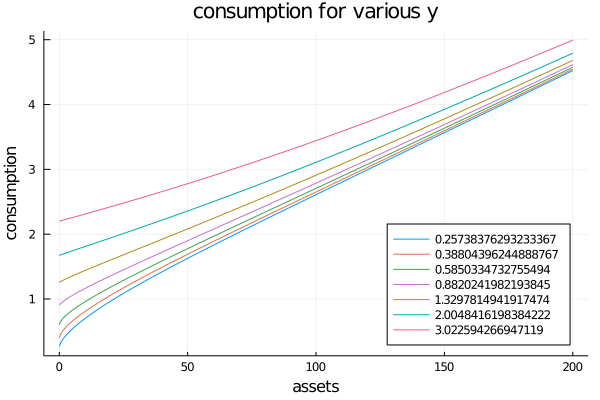

In [108]:
@unpack Amat, ygrid = hh

c, policyfun = iterate_egm(hh, r = 0.01)

plot(Amat[:,1], c, label = ygrid', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)


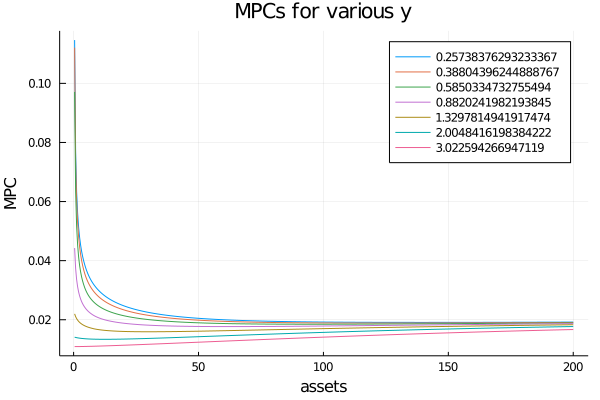

In [109]:
function MPC(a, grid)
    b = similar(a)
    b[1] = 0
    for i = 2:length(a)
         b[i] = (a[i] - a[i-1])/(grid[i] - grid[i-1])
    end
    return b
end

p = plot()
for i = 1:length(c[1,:])
    prop = MPC(c[:,i],Amat[:,1])
    plot!(p, Amat[2:end,1], prop[2:end])
end

plot(p, xlabel = "assets", ylabel = "MPC", title = "MPCs for various y", label = ygrid')